# Graphein - Residue Graph Tutorial

In this notebook, we'll run through residue-level graph construction in Graphein. We start by discsussing the config, the high-level API and spend the bulk of the tutorial running through the various options. At the end we'll see how the low-level API can be used to control each step of the graph construction process.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/a-r-j/graphein/blob/master/notebooks/residue_graphs.ipynb)

In [3]:
# Install Graphein if necessary
# !pip install graphein

# Install pymol if necessary - in this tutorial PyMol is only used for the initial plot. Feel free to skip!
# sudo apt-get install pymol (recommended for colab) OR conda install -c schrodinger pymol

First, let's checkout the protein we'll be playing with today:

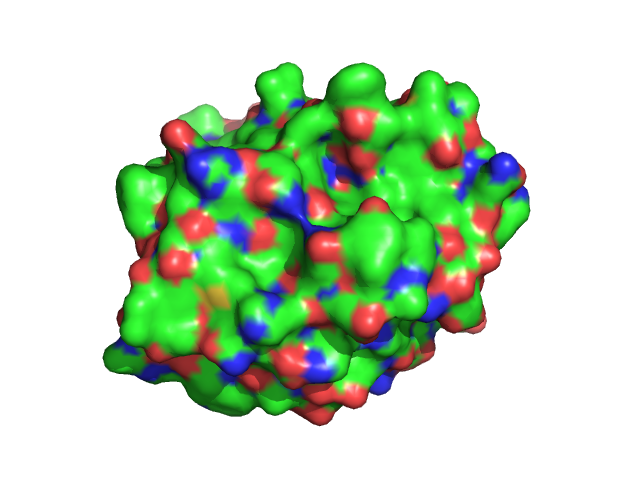

In [2]:
# NBVAL_SKIP
from graphein.utils.pymol import MolViewer
pymol = MolViewer()
pymol.delete("all") # delete all objects from other sessions if necessary.
pymol.fetch("3eiy")
pymol.show_as("cartoon")
pymol.display()

## Config
Graphein is designed for processing datasets of protein structures into graphs. We rely on a global config object, [`ProteinGraphConfig`](https://graphein.ai/modules/graphein.protein.html#graphein.protein.config.ProteinGraphConfig) to store various parameters in the high-level API. We use [`pydantic`](https://pydantic-docs.helpmanual.io/) for the config object and provide sane defaults.

In [4]:
from graphein.protein.config import ProteinGraphConfig

config = ProteinGraphConfig()
config.dict()

{'granularity': 'CA',
 'keep_hets': False,
 'insertions': False,
 'pdb_dir': PosixPath('../examples/pdbs'),
 'verbose': False,
 'exclude_waters': True,
 'deprotonate': False,
 'protein_df_processing_functions': None,
 'edge_construction_functions': [<function graphein.protein.edges.distance.add_peptide_bonds(G: 'nx.Graph') -> 'nx.Graph'>],
 'node_metadata_functions': [<function graphein.protein.features.nodes.amino_acid.meiler_embedding(n, d, return_array: bool = False) -> Union[pandas.core.series.Series, <built-in function array>]>],
 'edge_metadata_functions': None,
 'graph_metadata_functions': None,
 'get_contacts_config': None,
 'dssp_config': None}

Let's run through the parameters of [`ProteinGraphConfig`](https://graphein.ai/modules/graphein.protein.html#graphein.protein.config.ProteinGraphConfig):

* `granularity`: specifies the granularity of the graph (i.e. what should the nodes be). Possible values are: atom identifiers (e.g. `"CA"` for $\alpha$ carbon, `"CB"` for $\beta$ carbon), `"centroid"` to use residue centroids (under the hood, this is the same as `"CA"`, but we use the average `x,y,z` coordinates for the atoms in the residue) or "atom" for atom-level construction. This is discussed in another notebook.
* `keep_hets`: this is a boolean specifying whether or not to keep heteroatoms present in the `.pdb` file. Heteroatoms are typically non-protein atoms (waters, metal ions, ligands) but can sometimes contain non-standard or modified residues.
* `insertions`: boolean specifying whether or not to keep insertions in the PDB file
* `pdb_dir` optional path to a folder in which to save pdb files. Otherwise, `/tmp/` will be used
* `verbose`: bool controlling amount of info printed
* `exclude_waters`: not implemented
* `deprotonate`: bool indicating whether or not to remove Hydrogen atoms
* `protein_df_processing_functions`: list of functions with which to process the PDB dataframe. Discussed in the low-level API.
* `edge_construction_functions`: list of functions to compute edges with
* `node_metadata_functions`: list of functions to annotate nodes with
* `edge_metadata_functions`: list of functions to annotate edges with
* `graph_meta_functions`: list of functions to annotate graph with
* `get_contacts_config`: A separate config object if using ``GetContacts`` edge construction functions

If you wish, you can construct an entirely fresh configuration. Or, if we wish to change only some of these parameters, we can pass a dictionary containing our modifications:

In [5]:
params_to_change = {"granularity": "centroids"}

config = ProteinGraphConfig(**params_to_change)
config.dict()

{'granularity': 'centroids',
 'keep_hets': False,
 'insertions': False,
 'pdb_dir': PosixPath('../examples/pdbs'),
 'verbose': False,
 'exclude_waters': True,
 'deprotonate': False,
 'protein_df_processing_functions': None,
 'edge_construction_functions': [<function graphein.protein.edges.distance.add_peptide_bonds(G: 'nx.Graph') -> 'nx.Graph'>],
 'node_metadata_functions': [<function graphein.protein.features.nodes.amino_acid.meiler_embedding(n, d, return_array: bool = False) -> Union[pandas.core.series.Series, <built-in function array>]>],
 'edge_metadata_functions': None,
 'graph_metadata_functions': None,
 'get_contacts_config': None,
 'dssp_config': None}

## High-level API
Graphein features a high-level API which should be applicable for most simple graph constructions. This can be used on either a `.pdb` file (so you can run whatever pre-processing you wish), or we can provide a PDB accession code and retrieve a structure from the PDB itself. If a path is provided, it takes precedence over the PDB code.

To use it we do as follows:

In [6]:
from graphein.protein.graphs import construct_graph

g = construct_graph(config=config, pdb_code="3eiy")

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Converting dataframe to centroids. This averages XYZ coords of the atoms in a residue
DEBUG:graphein.protein.graphs:Calculated 174 centroid nodes
DEBUG:graphein.protein.graphs:Detected 174 total nodes
DEBUG:graphein.protein.features.nodes.amino_acid:Reading meiler embeddings from: /Users/arianjamasb/github/graphein/graphein/protein/features/nodes/meiler_embeddings.csv


If you wish to use a local `.pdb` file, you can run:

```python
g = construct_graph(config=config, pdb_path="../graphein/examples/pdbs/3eiy.pdb")
```

Let's check out the results with the in-built visualisation

In [7]:
from graphein.protein.visualisation import plotly_protein_structure_graph

p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="degree",
    label_node_ids=False,
    plot_title="Peptide backbone graph. Nodes coloured by degree.",
    node_size_multiplier=1
    )
p.show()

`Cool! So let's look at what we've got here:

We've plotted the graph, positioning nodes according to their `x,y,z` coordinates and coloured them by their degree. As we can see all the nodes are yellow except the two corresponding to the N and C terminal residues. Why is this? Because we've only computed the peptide-bond edges. Now, we probably want more so let's look at how to do that!

### Edge Functions
Graphein is implemented in a functional fashion. In this case, this means in order to compute edges, we pass a list of edge construction functions to the construction. We have supplied a number of edge computation functions. These are located in:
* [`graphein.protein.edges.distance`](https://graphein.ai/modules/graphein.protein.html#module-graphein.protein.edges.distance)
* [`graphein.protein.edges.intramolecular`](https://graphein.ai/modules/graphein.protein.html#module-graphein.protein.edges.intramolecular) (these rely on an installation of [GetContacts](https://getcontacts.github.io/), an optional dependency) and a separate [GetContactsConfig](https://graphein.ai/modules/graphein.protein.html#graphein.protein.config.GetContactsConfig)
* [`graphein.protein.edges.atomic`](https://graphein.ai/modules/graphein.protein.html#module-graphein.protein.edges.atomic) (these are used in atomic-level graphs and we discuss these in [another notebook tutorial](https://graphein.ai/notebooks/atom_graph_tutorial.html))

However, edge functions are simple functions that take in an `nx.Graph` and return an `nx.Graph` with added edges. This means users can easily define their own to suit their purposes! Let's take a closer look at some of the in-built functions before defining our own.

#### Built-in Edge Functions

In [10]:
from graphein.protein.edges.distance import add_hydrogen_bond_interactions, add_peptide_bonds

new_edge_funcs = {"edge_construction_functions": [add_peptide_bonds, add_hydrogen_bond_interactions]}
config = ProteinGraphConfig(**new_edge_funcs)


g = construct_graph(config=config, pdb_code="3eiy")
p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="seq_position",
    label_node_ids=False,
    plot_title="Protein graph with peptide backbone and H-Bonds. \n Nodes coloured by sequence position. Edges coloured by type.",
    node_size_multiplier=1,
    )
p.show()

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Detected 174 total nodes
INFO:graphein.protein.edges.distance:Found 75 hbond interactions.
INFO:graphein.protein.edges.distance:Found 7 hbond interactions.


Great! So what if we try __a bunch__ of them

In [11]:
from graphein.protein.edges.distance import (add_peptide_bonds,
                                             add_hydrogen_bond_interactions,
                                             add_disulfide_interactions,
                                             add_ionic_interactions,
                                             add_aromatic_interactions,
                                             add_aromatic_sulphur_interactions,
                                             add_cation_pi_interactions
                                            )

new_edge_funcs = {"edge_construction_functions": [add_peptide_bonds,
                                                  add_aromatic_interactions,
                                                  add_hydrogen_bond_interactions,
                                                  add_disulfide_interactions,
                                                  add_ionic_interactions,
                                                  add_aromatic_sulphur_interactions,
                                                  add_cation_pi_interactions]
                 }

config = ProteinGraphConfig(**new_edge_funcs)
g = construct_graph(config=config, pdb_code="3eiy")
p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="seq_position",
    label_node_ids=False,
    plot_title="Protein graph with: peptide backbone, H-Bonds, \n Disulphide, ionic, aromatic, aromatic-sulphur and cation-pi interactions. \n  Nodes coloured by sequence position, edges by type",
    node_size_multiplier=1
    )
p.show()

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Detected 174 total nodes
INFO:graphein.protein.edges.distance:Found: 16 aromatic-aromatic interactions
INFO:graphein.protein.edges.distance:Found 75 hbond interactions.
INFO:graphein.protein.edges.distance:Found 7 hbond interactions.
DEBUG:graphein.protein.edges.distance:1 CYS residues found. Cannot add disulfide interactions with fewer than two CYS residues.
INFO:graphein.protein.edges.distance:Found 175 ionic interactions.


Cool! So we've added a bunch on distance-based computations of intramolecular edges to our graph! We have a few more distance based edge functions that we can visualise. Let's check them out!

* [`graphein.protein.edges.distance.add_delaunay_triangulation`](https://graphein.ai/modules/graphein.protein.html#graphein.protein.edges.distance.add_delaunay_triangulation): Adds edges based on the delaunay triangulation
* [`graphein.protein.edges.distance.add_k_nn_edges`](https://graphein.ai/modules/graphein.protein.html#graphein.protein.edges.distance.add_k_nn_edges): Adds edges based on K Nearest neighbours
* [`graphein.protein.edges.distance.add_distance_threshold`](https://graphein.ai/modules/graphein.protein.html#graphein.protein.edges.distance.add_distance_threshold): Adds edges based on distance cutoff in Angstroms

First up, the Delaunay triangulation:

In [12]:
from graphein.protein.edges.distance import add_delaunay_triangulation

new_edge_funcs = {"edge_construction_functions": [add_delaunay_triangulation]}
config = ProteinGraphConfig(**new_edge_funcs)

g = construct_graph(config=config, pdb_code="3eiy")
p = plotly_protein_structure_graph(
    G=g,
    colour_edges_by="kind",
    colour_nodes_by="seq_position",
    label_node_ids=False,
    node_size_multiplier=1,
    plot_title="Protein graph created by the Delaunay triangulation of the structure. \n Nodes coloured by sequence position."
    )
p.show()

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Detected 174 total nodes
DEBUG:graphein.protein.edges.distance:Detected 954 simplices in the Delaunay Triangulaton.


Next, let's consider the last two edge construction functions [`add_k_nn_edges`](https://graphein.ai/modules/graphein.protein.html#graphein.protein.edges.distance.add_k_nn_edges) and [`add_distance_threshold`](https://graphein.ai/modules/graphein.protein.html#graphein.protein.edges.distance.add_distance_threshold). These two functions take additional parameters. We can manage this with partial functions. These functions also feature a `long_interaction_threshold` parameter which specifies the minimum number of residues in the sequence between two residues in order to add an edge. This is because we may not be so interested in residues close together in the sequence being close together in the graph.

In [13]:
from functools import partial
from graphein.protein.edges.distance import add_distance_threshold

new_edge_funcs = {"edge_construction_functions": [partial(add_distance_threshold, long_interaction_threshold=5, threshold=10.)]}
config = ProteinGraphConfig(**new_edge_funcs)

g = construct_graph(config=config, pdb_code="3eiy")
p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="seq_position",
    label_node_ids=False,
    plot_title="Protein graph created by thresholding distance between nodes. \n Nodes must be <10A apart and at least 5 positions apart \n Nodes coloured by sequence position.",
    node_size_multiplier=1
    )
p.show()

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Detected 174 total nodes


In [14]:
from functools import partial
from graphein.protein.edges.distance import add_k_nn_edges

new_edge_funcs = {"edge_construction_functions": [partial(add_k_nn_edges, k=3, long_interaction_threshold=0)]}
config = ProteinGraphConfig(**new_edge_funcs)

g = construct_graph(config=config, pdb_code="3eiy")
p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="seq_position",
    label_node_ids=False,
    plot_title="Protein graph created from K-NN of each node. Nodes coloured by sequence position",
    node_size_multiplier=1
    )
p.show()

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Detected 174 total nodes


#### Defining your own edge functions
Now, let's turn our attention to defining our own edge construction functions. These must take in a `nx.Graph` and return a `nx.Graph`. You can use these custom functions together with all the in-built edge functions as before. If you come up with something cool, consider making a pull-request and sharing it with the community!

Here, as an example, we define an arbitrary function that creates an edge between all histidine residues in the graph.

In [15]:
import networkx as nx

def add_histidine_histidine_edges(G: nx.Graph) -> nx.Graph:
    # Iterate over nodes to identify histidines
    histidines = [n for n, d in G.nodes(data=True) if d["residue_name"] == "HIS"]

    # Iterate over histidines and create a bond between them
    [G.add_edge(x, y, kind={"histidine"}) for i, x in enumerate(histidines) for j, y in enumerate(histidines) if i!=j]
    return G

In [16]:
new_edge_funcs = {"edge_construction_functions": [add_histidine_histidine_edges]}
config = ProteinGraphConfig(**new_edge_funcs)

g = construct_graph(config=config, pdb_code="3eiy")
p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="seq_position",
    label_node_ids=False,
    plot_title="Protein graph created using a user-defined function that connects all Histidines."
    )
p.show()
# Let's check this worked:
for u, v, a in g.edges(data=True):
    print(u, v, a)

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Detected 174 total nodes


A:HIS:111 A:HIS:137 {'kind': {'histidine'}}
A:HIS:111 A:HIS:163 {'kind': {'histidine'}}
A:HIS:137 A:HIS:163 {'kind': {'histidine'}}


### Features & Metadata
`Graphein` is designed to facilitate geometric deep learning on protein structures and so we have a bunch of feature and metadata annotation functions. These operate on three levels:
* node-level annotation
* graph-level annotation
* edge-level annotation

These behave very similarly to the edge construction functions we just looked at. You simply pass a list of functions that take the right sort of arguments and return the right types. 

* graph-level annotation takes in a `nx.Graph` and returns an `nx.Graph` (just like before!).
* node-level annotation takes in a node, data tuple from `G.nodes(data=True)` and returns a `pd.Series`
* edge-level annotation in node_u, node_v, data tuple from `G.edges(data=True)` and returns 

#### Built-in Graph Annotation Functions
These are found in `graphein.protein.features.sequence` and `graphein.protein.features.graph`. We make a slight distinction between those functions that operate on the protein sequence for cleaner organisation. N.B. we've mentioned the `chain_selection` parameter briefly - if you include multiple chains in your graph, then will be multiple sequences associated with it. These are accessed as such: `G.graph[f"sequence_{CHAIN_ID}"]` and features computed from sequence are accessed as: `G.graph[f"{FEATURE_NAME}_{CHAIN_ID}]`

In [17]:
from graphein.protein.features.sequence.sequence import molecular_weight

new_graph_annotation_funcs = {"graph_metadata_functions": [molecular_weight]}
config = ProteinGraphConfig(**new_graph_annotation_funcs)

g = construct_graph(config=config, pdb_code="3eiy")
print("Sequence:", g.graph["sequence_A"])
print("MW:", g.graph["molecular_weight_A"])

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Detected 174 total nodes


Sequence: SFSNVPAGKDLPQDFNVIIEIPAQSEPVKYEADKALGLLVVDRFIGTGMRYPVNYGFIPQTLSGDGDPVDVLVITPFPLLAGSVVRARALGMLKMTDESGVDAKLVAVPHDKVCPMTANLKSIDDVPAYLKDQIKHFFEQYKALEKGKWVKVEGWDGIDAAHKEITDGVANFKK
MW: 19029.71029999999


We also provide some utilities for adding graph-level features in the form of sequence embeddings from various pre-trained language models. Let's check them out!

In [18]:
# Warning! This cell may crash a binder notebook as the pre-trained model download is rather large!
# NBVAL_SKIP
from graphein.protein.features.sequence.embeddings import esm_sequence_embedding, biovec_sequence_embedding

new_graph_annotation_funcs = {"graph_metadata_functions": [esm_sequence_embedding, biovec_sequence_embedding]}
config = ProteinGraphConfig(**new_graph_annotation_funcs)

g = construct_graph(config=config, pdb_code="3eiy")
print("ESM:", g.graph["esm_embedding_A"])
print("biovec:", g.graph["biovec_embedding_A"])

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Detected 174 total nodes
Using cache found in /Users/arianjamasb/.cache/torch/hub/facebookresearch_esm_master
/Users/arianjamasb/opt/anaconda3/envs/graphein-wip/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning:

Failed to load image Python extension: dlopen(/Users/arianjamasb/opt/anaconda3/envs/graphein-wip/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: /Users/arianjamasb/opt/anaconda3/envs/graphein-wip/lib/python3.8/site-packages/torchvision/image.so
  Expected in: /Users/arianjamasb/opt/anaconda3/envs/graphein-wip/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib

INFO:gensim.utils:loading Word2Vec object from /Users/arian

ESM: [-0.02279943  0.16464774 -0.00461995 ...  0.02556622 -0.19798394
  0.09682215]
biovec: [array([ -8.865931  ,   5.65769   ,  -1.5052402 ,   3.2893941 ,
        -6.6228924 ,   2.4890645 ,   1.0635861 ,   2.4991994 ,
        -2.2740204 ,  -7.6614437 ,   0.3739053 ,   4.285517  ,
        -1.7950253 ,  -2.0930681 ,   0.19075748,   9.249631  ,
        -1.2537682 ,   6.0140305 ,  -3.0592997 ,   3.1944623 ,
         5.6747837 ,   1.4732779 ,  -9.556535  ,   4.5126605 ,
       -15.789192  ,  -9.917104  ,  10.61495   ,   1.6693095 ,
         1.8446481 , -12.656563  ,   2.5226657 ,   3.2782233 ,
         5.6363025 ,  -1.5776551 ,   9.913681  ,  -1.4776824 ,
         7.4292827 ,   2.6953607 ,  -0.81495905,   1.0415509 ,
       -18.352554  ,  -9.603085  , -11.215957  ,   3.9449768 ,
         2.2988393 ,   2.8612108 ,  -5.647224  ,  -9.894558  ,
         2.8099368 ,  -3.47802   ,  -1.7364154 ,   4.10581   ,
        -1.1337806 ,  -7.851351  ,   3.667841  ,   2.5098174 ,
         0.3878222 ,  -0.

#### Writing your own graph-level annotation function.
We provide a couple of useful functions for dealing with multiple chains robustly, namely `compute_feature_over_chains` and `aggregate_feature_over_chains`. This takes an input (`nx.Graph`), your function: (`Callable`), and feature_name (`str`). Your function must operate on a sequence (`str`) to use this utility.

`aggregate_feature_over_chains` can be used to perform aggregation `{"min", "max", "sum" , "mean"}` of chain-specific features. It takes: an `nx.Graph`, a feature name (`str`) and and aggregation type (`str`)

If you don't want to operate on the sequnce, you don't need to use these!

Let's use this to construct a graph-level feature that operates on the sequence. This feature is an integer equal to the number of histidines in the chain.

In [19]:
from graphein.protein.features.sequence.utils import compute_feature_over_chains, aggregate_feature_over_chains

# Define our graph-level function that operates on sequences
def histidine_count_feature(G: nx.Graph) -> nx.Graph:

    # Define our feature function that operates on a sequence
    def count_histidines(sequence: str) -> int:
         return sequence.count("H")
        
    # Compute the feature over the chains in the graph
    G = compute_feature_over_chains(G, func=count_histidines, feature_name="histidine_count")
    
    # Aggregate the feature over the chains
    G = aggregate_feature_over_chains(G, feature_name="histidine_count", aggregation_type="mean")
    return G


new_graph_annotation_funcs = {"graph_metadata_functions": [histidine_count_feature]}
config = ProteinGraphConfig(**new_graph_annotation_funcs)

# Test our new feature
g = construct_graph(config=config, pdb_code="3eiy")
print(g.graph["histidine_count_A"])

# And now on a multi-chain graph
g = construct_graph(config=config, pdb_code="9API", chain_selection="all")
print("Chain A Hists:", g.graph["histidine_count_A"])
print("Chain B Hists:", g.graph["histidine_count_B"])
print("Chain B Seq:", g.graph["sequence_B"])
print("Aggregated HIS count:", g.graph["histidine_count_mean"])

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Detected 174 total nodes


3


DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Detected 375 total nodes


Chain A Hists: 11
Chain B Hists: 0
Chain B Seq: SIPPEVKFNKPFVFLMIEQNTKSPLFMGKVVNPTQK
Aggregated HIS count: 5.5


#### Node-level features
Similarly, we provide some in-built functions for computing node-level features. For example, we'll look at some featurisations of amino acid types.

First, we'll look at a simple one-hot encoding of the amino acid type


In [20]:
from graphein.protein.features.nodes.amino_acid import amino_acid_one_hot

config = ProteinGraphConfig(**{"node_metadata_functions": [amino_acid_one_hot]})
g = construct_graph(config=config, pdb_code="3eiy")

for n, d in g.nodes(data=True):
    print(d["amino_acid_one_hot"])

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Detected 174 total nodes


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0

In [21]:
from graphein.protein.features.nodes.amino_acid import expasy_protein_scale

config = ProteinGraphConfig(**{"node_metadata_functions": [expasy_protein_scale]})
g = construct_graph(config=config, pdb_code="3eiy")

for n, d in g.nodes(data=True):
    print(d['expasy'])
    break

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Detected 174 total nodes
DEBUG:graphein.protein.features.nodes.amino_acid:Reading Expasy protein scales from: /Users/arianjamasb/github/graphein/graphein/protein/features/nodes/amino_acid_properties.csv


pka_cooh_alpha               2.21
pka_nh3                      9.15
pka_rgroup                   7.00
isoelectric_points           5.68
molecularweight            105.00
                            ...  
antiparallelbeta_strand      0.87
parallelbeta_strand          0.70
a_a_composition              6.90
a_a_swiss_prot               6.56
relativemutability         120.00
Name: SER, Length: 61, dtype: float64


#### Geometric features

[API Reference](https://graphein.ai/modules/graphein.protein.html#graphein.protein.features.nodes.geometry)

We can also add geometric features to protein structure graphs.

In [30]:
from graphein.protein.features.nodes.geometry import add_sidechain_vector, add_beta_carbon_vector, add_sequence_neighbour_vector
from graphein.protein.visualisation import add_vector_to_plot

add_sidechain_vector(g)
add_beta_carbon_vector(g)
add_sequence_neighbour_vector(g)

fig = plotly_protein_structure_graph(g, node_size_multiplier=1)
fig = add_vector_to_plot(g, fig, "sidechain_vector", colour="red", scale=1.5)
fig = add_vector_to_plot(g, fig, "c_beta_vector", colour="blue", scale=1.5)
fig = add_vector_to_plot(g, fig, "sequence_neighbour_vector_n_to_c", colour="green", scale=1.5)
fig

## Low-Level API

Graphein also features a low-level API if you want to get down into the gritty details of the construction. Essentially, every step of the construction is a function that you can tweak/alter the sequencing of as you please. This is __very__ flexible if not unnecessary for most applications

### Pre-Processing
All graphs begin as `pd.DataFrame` representations of the .PDB file. These are handled by PandasPDB. There is a convenience function here `process_dataframe`, to which you can pass a list of dataframe processing functions. These are similar to the edge construction and annotation functions described above except they take in a `pd.DataFrame` and return a `pd.DataFrame`. We'll start by reimplementing the construction we've been using above.

In [50]:
from graphein.protein.graphs import read_pdb_to_dataframe, process_dataframe, deprotonate_structure, convert_structure_to_centroids, subset_structure_to_atom_type, filter_hetatms, remove_insertions

processing_funcs = [deprotonate_structure, convert_structure_to_centroids, remove_insertions]


pdb_code = "3eiy"
# Read dataframe from PDB
raw_df = read_pdb_to_dataframe(pdb_code=pdb_code)

# Apply processing functions
df = process_dataframe(raw_df, atom_df_processing_funcs = processing_funcs)
df.head()

DEBUG:graphein.protein.graphs:Deprotonating protein. This removes H atoms from the pdb_df dataframe
DEBUG:graphein.protein.graphs:Converting dataframe to centroids. This averages XYZ coords of the atoms in a residue
DEBUG:graphein.protein.graphs:Calculated 174 centroid nodes


,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx,node_id
0,ATOM,2,,CA,,SER,,A,2,,...,54.615500,-0.136833,1.0,52.54,,,C,NaN,610,A:SER:2
1,ATOM,8,,CA,,PHE,,A,3,,...,51.417273,2.656727,1.0,48.73,,,C,NaN,616,A:PHE:3
2,ATOM,19,,CA,,SER,,A,4,,...,50.090833,-2.889667,1.0,47.00,,,C,NaN,627,A:SER:4
3,ATOM,25,,CA,,ASN,,A,5,,...,52.759000,-4.146375,1.0,41.42,,,C,NaN,633,A:ASN:5
4,ATOM,33,,CA,,VAL,,A,6,,...,51.575429,0.109000,1.0,32.41,,,C,NaN,641,A:VAL:6


We can define our own processing functions. Here we define a function that removes odd numbered residues from the dataframe. We'll use this again later.

In [51]:
import pandas as pd

def remove_odd_resis(df: pd.DataFrame) -> pd.DataFrame:
    return df.loc[df.index % 2 == 0]

remove_odd_resis(df).head()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx,node_id
0,ATOM,2,,CA,,SER,,A,2,,...,54.615500,-0.136833,1.0,52.54,,,C,NaN,610,A:SER:2
2,ATOM,19,,CA,,SER,,A,4,,...,50.090833,-2.889667,1.0,47.00,,,C,NaN,627,A:SER:4
4,ATOM,33,,CA,,VAL,,A,6,,...,51.575429,0.109000,1.0,32.41,,,C,NaN,641,A:VAL:6
6,ATOM,47,,CA,,ALA,,A,8,,...,46.781200,0.618800,1.0,25.67,,,C,NaN,655,A:ALA:8
8,ATOM,56,,CA,,LYS,,A,10,,...,51.873333,1.231222,1.0,27.63,,,C,NaN,664,A:LYS:10


### Building the Graph
First we initialise the graph with the metadata. We then use this to add the nodes

In [52]:
from graphein.protein.graphs import initialise_graph_with_metadata, add_nodes_to_graph

g = initialise_graph_with_metadata(protein_df=df, # from above cell
                                   raw_pdb_df=raw_df.df["ATOM"], # Store this for traceability
                                   pdb_code = pdb_code, #and again
                                   granularity = "centroid" # Store this so we know what kind of graph we have
                                  )

g = add_nodes_to_graph(g)
print(g.nodes)

['A:SER:2', 'A:PHE:3', 'A:SER:4', 'A:ASN:5', 'A:VAL:6', 'A:PRO:7', 'A:ALA:8', 'A:GLY:9', 'A:LYS:10', 'A:ASP:11', 'A:LEU:12', 'A:PRO:13', 'A:GLN:14', 'A:ASP:15', 'A:PHE:16', 'A:ASN:17', 'A:VAL:18', 'A:ILE:19', 'A:ILE:20', 'A:GLU:21', 'A:ILE:22', 'A:PRO:23', 'A:ALA:24', 'A:GLN:25', 'A:SER:26', 'A:GLU:27', 'A:PRO:28', 'A:VAL:29', 'A:LYS:30', 'A:TYR:31', 'A:GLU:32', 'A:ALA:33', 'A:ASP:34', 'A:LYS:35', 'A:ALA:36', 'A:LEU:37', 'A:GLY:38', 'A:LEU:39', 'A:LEU:40', 'A:VAL:41', 'A:VAL:42', 'A:ASP:43', 'A:ARG:44', 'A:PHE:45', 'A:ILE:46', 'A:GLY:47', 'A:THR:48', 'A:GLY:49', 'A:MET:50', 'A:ARG:51', 'A:TYR:52', 'A:PRO:53', 'A:VAL:54', 'A:ASN:55', 'A:TYR:56', 'A:GLY:57', 'A:PHE:58', 'A:ILE:59', 'A:PRO:60', 'A:GLN:61', 'A:THR:62', 'A:LEU:63', 'A:SER:64', 'A:GLY:65', 'A:ASP:66', 'A:GLY:67', 'A:ASP:68', 'A:PRO:69', 'A:VAL:70', 'A:ASP:71', 'A:VAL:72', 'A:LEU:73', 'A:VAL:74', 'A:ILE:75', 'A:THR:76', 'A:PRO:77', 'A:PHE:78', 'A:PRO:79', 'A:LEU:80', 'A:LEU:81', 'A:ALA:82', 'A:GLY:83', 'A:SER:84', 'A:VAL:85',

Next, we add edges to the graph:

In [53]:
from graphein.protein.graphs import compute_edges
g = compute_edges(g, get_contacts_config=None, funcs=[add_peptide_bonds, add_hydrogen_bond_interactions])
print(g.edges)

INFO:graphein.protein.edges.distance:Found 75 hbond interactions.
INFO:graphein.protein.edges.distance:Found 7 hbond interactions.


[('A:SER:2', 'A:PHE:3'), ('A:PHE:3', 'A:SER:4'), ('A:SER:4', 'A:ASN:5'), ('A:ASN:5', 'A:VAL:6'), ('A:VAL:6', 'A:PRO:7'), ('A:PRO:7', 'A:ALA:8'), ('A:ALA:8', 'A:GLY:9'), ('A:GLY:9', 'A:LYS:10'), ('A:LYS:10', 'A:ASP:11'), ('A:ASP:11', 'A:LEU:12'), ('A:LEU:12', 'A:PRO:13'), ('A:PRO:13', 'A:GLN:14'), ('A:GLN:14', 'A:ASP:15'), ('A:ASP:15', 'A:PHE:16'), ('A:ASP:15', 'A:ARG:87'), ('A:PHE:16', 'A:ASN:17'), ('A:ASN:17', 'A:VAL:18'), ('A:VAL:18', 'A:ILE:19'), ('A:ILE:19', 'A:ILE:20'), ('A:ILE:20', 'A:GLU:21'), ('A:GLU:21', 'A:ILE:22'), ('A:ILE:22', 'A:PRO:23'), ('A:PRO:23', 'A:ALA:24'), ('A:ALA:24', 'A:GLN:25'), ('A:GLN:25', 'A:SER:26'), ('A:SER:26', 'A:GLU:27'), ('A:GLU:27', 'A:PRO:28'), ('A:PRO:28', 'A:VAL:29'), ('A:VAL:29', 'A:LYS:30'), ('A:LYS:30', 'A:TYR:31'), ('A:TYR:31', 'A:GLU:32'), ('A:GLU:32', 'A:ALA:33'), ('A:ALA:33', 'A:ASP:34'), ('A:ASP:34', 'A:LYS:35'), ('A:LYS:35', 'A:ALA:36'), ('A:ALA:36', 'A:LEU:37'), ('A:LEU:37', 'A:GLY:38'), ('A:GLY:38', 'A:LEU:39'), ('A:LEU:39', 'A:LEU:40'), 

Let's check it out!

In [55]:
p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="seq_position",
    label_node_ids=False,
    plot_title="Protein graph created using low-level API. Shows peptide bond back bond and H-Bonds",
    node_size_multiplier=1
    )
p.show()

Just as we expected! From here we can apply any number of graph, node or edge metadata annotation functions that we may wish to. The advantage here is that we are not tied to the sequencing in the high-level API of:

(annotate node metadata -> compute edges -> annotate graph metadata -> annotate edge metadata). 

This means, if we want, we can define graph annotation functions that utilise edge metadata that would otherwise not be possible. E.g. here we annotate bonds containing histidines with a 1. We then define a graph feature that looks for these bonds, sums the residue numbers involved and sums them.

In [56]:
from graphein.protein.graphs import annotate_node_metadata, annotate_graph_metadata, annotate_edge_metadata

# Define edge feature that assigns hist_status = 1 to any bond involving a histidine
def bond_has_histidine_edge_feature(u, v, d):
    if "HIS" in u or "HIS" in v:
        d["hist_status"] = 1
    else:
        d["hist_status"] = 0
        
# Annotate the edge metadata
g = annotate_edge_metadata(g, [bond_has_histidine_edge_feature])

# Check it out
for u, v, d in g.edges(data=True):
    if d["hist_status"] == 1:
        print(u, v, d)

# Annotate graph-level feature that depends on histidine_status edge feature. This adds the sum of the residue numbers involved in hist_status bonds
def sum_hist_status_bond_residue_nums(G: nx.Graph) -> nx.Graph:
    to_add = []

    for u, v, a in G.edges(data=True):
        if a["hist_status"] == 1:
            to_add.append(G.nodes[u]["residue_number"])
            to_add.append(G.nodes[v]["residue_number"])

    total = sum(to_add)

    G.graph["hist_bond_total_residue_number"] = total
    return G


g = annotate_graph_metadata(g, [sum_hist_status_bond_residue_nums])
print("Graph-level hist feature:", g.graph["hist_bond_total_residue_number"])

A:PRO:110 A:HIS:111 {'kind': {'peptide_bond'}, 'hist_status': 1}
A:HIS:111 A:ASP:112 {'kind': {'peptide_bond'}, 'hist_status': 1}
A:LYS:136 A:HIS:137 {'kind': {'peptide_bond'}, 'hist_status': 1}
A:HIS:137 A:PHE:138 {'kind': {'peptide_bond'}, 'hist_status': 1}
A:ALA:162 A:HIS:163 {'kind': {'peptide_bond'}, 'hist_status': 1}
A:HIS:163 A:LYS:164 {'kind': {'peptide_bond'}, 'hist_status': 1}
Graph-level hist feature: 1644


_fin_